In [5]:
%matplotlib inline
#%qtconsole

import os
import cPickle
import numpy as np
import pandas
from scipy import linalg
import scipy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, date2num, num2date
from load_gridded_data import read_gridded_data_CMIP5_model
from gridAvg import gridAvg
import wd

In [23]:
# Load various model output and interpolate to CCSM4 resolution

# CHANGE THIS TO USE THE SAME SORT OF STRUCTURE THAT dd is!

from scipy import interpolate
import gridAvg

data_dir = '/Users/dan/Desktop/CCSM4_ctrl/'
data_files = ['tas_sfc_Amon_CCSM4_past1000_085001-185012.nc',
              'HadCM3/tas_sfc_Amon_HadCM3_past1000_085001-185012.nc',
              'MPI/tas_sfc_Amon_MPI-ESM-P_past1000_085001-185012.nc']
model_names = ['CCSM4','HadCM3','MPI-ESM']
data_vars = {'tas_sfc_Amon':0}

outtimeavg = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
time = np.arange(850,1851)

ad = []

for ii in np.arange(len(data_files)):
#for ii in np.array([1]):
    
    data_file = data_files[ii]
    ny = 1000
    dd=read_gridded_data_CMIP5_model(data_dir,data_file,data_vars,outtimeavg,detrend=None)
    dd['model_name'] = model_names[ii]

    if ii==0:
        dd['datam'] = np.reshape(dd['tas_sfc_Amon']['value'][:ny,:,:],[ny,-1]).transpose()
        dd['data'] = dd['datam'] - np.tile(np.mean(dd['datam'],0),[max(dd['datam'].shape),1])
        # Kludge for now
        #dd['datam'] = dd['datam'].transpose()
        #dd['data'] = dd['data'].transpose()

    # If not the model we're, interpolate to CCSM4 grid.
    if ii!=0:
        x    = dd['tas_sfc_Amon']['lon']
        y    = dd['tas_sfc_Amon']['lat']
#        xx, yy = np.meshgrid(x,y)
        xnew = ad[0]['tas_sfc_Amon']['lon']
        ynew = ad[0]['tas_sfc_Amon']['lat']
        umhr = np.zeros(ad[0]['data'].shape)

        for jj in np.arange(ny):
            f = scipy.interpolate.RectBivariateSpline(y,x,dd['tas_sfc_Amon']['value'][jj,:,:].reshape(len(y),len(x)))
            umhr[:,jj] = f(ynew, xnew).ravel()

# Made some changes to get the dimensions consistent but haven't checked that anomalies make sense, so could be an error here!            
            
        dd['datam'] = umhr
        dd['data'] = dd['datam'] - np.tile(np.mean(dd['datam'],0),[max(dd['datam'].shape),1])
        dd['tas_sfc_Amon']['lat'] = ad[0]['tas_sfc_Amon']['lat']
        dd['tas_sfc_Amon']['lon'] = ad[0]['tas_sfc_Amon']['lon']

    ad.append(dd)



Reading file:  /Users/dan/Desktop/CCSM4_ctrl//tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.07237e-07  , std-dev= 1.88994
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.44248843524e-08  , std-dev= 0.831738641116
Reading file:  /Users/dan/Desktop/CCSM4_ctrl//HadCM3/tas_sfc_Amon_HadCM3_past1000_085001-185012.nc
(12012, 73, 96)
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= -3.07507e-07  , std-dev= 1.99639
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= -2.70041320594e-07  , std-dev= 0.843914735574
Reading file:  /Users/dan/Desktop/CCSM4_ctrl//MPI/tas_sfc_Amon_MPI-ESM-P_past1000_085001-185012.nc
(12000, 96, 192)
Anomalies provided as the prior: Removing the temporal mean (for

In [8]:
## Make a gridded average of normalized proxy data to use as a mask on the CCSM4 output
proxy_pandas_metafile = 'Pages2k_Metadata.df.pckl'
proxy_pandas_datafile = 'Pages2k_Proxies.df.pckl'

proxy_meta = pandas.read_pickle(proxy_pandas_metafile)
proxy_data = pandas.read_pickle(proxy_pandas_datafile)

# necessary to index this as I'd like. not sure why...
proxy_data.index=proxy_data.index.astype('float64')
proxy_data = proxy_data.astype('float64')

proxy_data = proxy_data[0:2011]

# Reformat the proxy_meta to get rid of special characters
proxy_meta.columns = [x.strip().replace(' ','_') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('(','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace(')','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('.','') for x in proxy_meta.columns]

# Change the metadata file so that indices are NCDC IDs (better matchup with data file)
proxy_meta.index = proxy_meta['PAGES_ID']
proxy_meta=proxy_meta.rename(columns = {'PAGES_ID':'NCDC_ID'})

# Replace all proxy types with a placeholder for now

proxy_meta['Archive_type'] = proxy_meta['Archive_type'].str.replace(' ','_')

# sort the metadata to have the same order as the data file
proxy_data = proxy_data.loc[:,proxy_meta.index]

# Remove one record that has a range of lat-lon values
proxy_data = proxy_data.drop('Eur_11',1)
proxy_meta = proxy_meta.drop('Eur_11',0)

proxy_data = proxy_data.dropna(1,'all')
proxy_meta = proxy_meta.loc[proxy_data.columns]

proxy_meta.loc[:,'Lat_N'] = proxy_meta.loc[:,'Lat_N'].astype('float64')
proxy_meta.loc[:,'Lon_E'] = proxy_meta.loc[:,'Lon_E'].astype('float64')

import gridAvg
reload( gridAvg )
from gridAvg import gridAvg
# For some reason lon goes from 0 to 359. but lat goes from -90 to 90. I'm treating it instead like it's going from -90 to 89...
xRes = 360. / len(ad[0]['tas_sfc_Amon']['lon'])
yRes = 180. / (len(ad[0]['tas_sfc_Amon']['lat']))

gridded, pmg, lat_g,lon_g = gridAvg(proxy_meta,proxy_data,xRes,yRes)

# Make a mask from the data
dmask = (np.nansum(gridded,0)!=0)

In [14]:
# Load the comparison object so I don't have to recompute

cd = np.load('compare1.npy');

In [ ]:
# Compare what happens for various truth-prior pairs

import wd; reload(wd)

# Array of dictionaries containing the different comparisons
cd = []

# Set proxy locations equal to the PAGES2k network sites. Since there is no observational noise,
# having additional obs makes no difference, so just one per gridbox with any number of proxies
MASK  = dmask
L = np.size(dmask)
Ldf = len(data_files)

# Make the H (data) matrix using MASK
H = np.eye(L)[np.ndarray.flatten(MASK,'C'),:]


rpt_p2k = np.zeros([Ldf,Ldf,L,1000])
rpt_all = np.zeros([Ldf,Ldf,L,1000])

counter = 0

for ii in np.arange(len(data_files)):

    prior = ad[ii]['data']
    #hbhi = scipy.linalg.pinv(np.linalg.multi_dot([H,prior,prior.T,H.T]))
    #bi = scipy.linalg.pinv(np.linalg.multi_dot([prior,prior.T]))

    hbhi = scipy.linalg.pinv( H.dot(prior).dot(prior.T.dot(H.T)),rcond=1 )

    # For a complete observing system, it's BB^{-1}. I want to save this i.t.o. its factors. 
    # Probably easiest to do with SVD. 
    # Just UU.T
    u = np.linalg.svd(prior,full_matrices=False)[0]

    for jj in np.arange(len(data_files)):
        if ii==jj:
            continue

        truth = ad[jj]['data']

        # Filtered truth ensemble using PAGES2k data distribution
        fp = np.linalg.multi_dot([prior,prior.T,H.T,hbhi,H,truth])
        # Filtered truth ensemble using complete data distribution
        fc = np.linalg.multi_dot([u,u.T,truth])

        # Eigenvectors of the nullspace uncertainty
        ufp,sfp,tmp = np.linalg.svd(truth-fp,full_matrices=False)
        ufc,sfc,tmp = np.linalg.svd(truth-fc,full_matrices=False)

        
        # Store this information in a dictionary
        c = {}
        c['Prior'] = model_names[ii]
        c['Truth'] = model_names[jj]
        c['Filtered truth ensemble using PAGES2k'] = fp
        c['Filtered truth ensemble using complete obs'] = fc
        c['Eigenvectors of nullspace unc using PAGES2k'] = ufp
        c['Eigenvectors of nullspace unc using complete obs'] = ufc
        c['Eigenvalues of nullspace unc using PAGES2k'] = sfp
        c['Eigenvalues of nullspace unc using complete obs'] = sfc
        
        #wd.plotMap_nl(lon_g,lat_g,sfp[0]*ufp[:,0].reshape(len(lat_g),len(lon_g)),'')

        # Concatenate the dictionary to a list corresponding to all prior-truth pairs
        cd.append(c)
        

In [ ]:
# DEBUGGING for HadCM3
# Compare what happens for various truth-prior pairs

import wd; reload(wd)

# Array of dictionaries containing the different comparisons
cd = []

# Set proxy locations equal to the PAGES2k network sites. Since there is no observational noise,
# having additional obs makes no difference, so just one per gridbox with any number of proxies
MASK  = dmask
L = np.size(dmask)
Ldf = len(data_files)

# Make the H (data) matrix using MASK
H = np.eye(L)[np.ndarray.flatten(MASK,'C'),:]

rpt_p2k = np.zeros([Ldf,Ldf,L,1000])
rpt_all = np.zeros([Ldf,Ldf,L,1000])

counter = 0

ii = 1
jj = 2

prior = ad[ii]['data']
#hbhi = scipy.linalg.pinv(np.linalg.multi_dot([H,prior,prior.T,H.T]))
#bi = scipy.linalg.pinv(np.linalg.multi_dot([prior,prior.T]))

hbhi = scipy.linalg.pinv( H.dot(prior).dot(prior.T.dot(H.T)) )

# For a complete observing system, it's BB^{-1}. I want to save this i.t.o. its factors. 
# Probably easiest to do with SVD. 
# Just UU.T
u = np.linalg.svd(prior,full_matrices=False)[0]

truth = ad[jj]['data']

# Filtered truth ensemble using PAGES2k data distribution
fp = np.linalg.multi_dot([prior,prior.T,H.T,hbhi,H,truth])
# Filtered truth ensemble using complete data distribution
fc = np.linalg.multi_dot([u,u.T,truth])

# Eigenvectors of the nullspace uncertainty
ufp,sfp,tmp = np.linalg.svd(truth-fp,full_matrices=False)
ufc,sfc,tmp = np.linalg.svd(truth-fc,full_matrices=False)

pdb.set_trace()

# Store this information in a dictionary
c = {}
c['Prior'] = model_names[ii]
c['Truth'] = model_names[jj]
c['Filtered truth ensemble using PAGES2k'] = fp
c['Filtered truth ensemble using complete obs'] = fc
c['Eigenvectors of nullspace unc using PAGES2k'] = ufp
c['Eigenvectors of nullspace unc using complete obs'] = ufc
c['Eigenvalues of nullspace unc using PAGES2k'] = sfp
c['Eigenvalues of nullspace unc using complete obs'] = sfc
c['hbhi'] = hbhi

#wd.plotMap_nl(lon_g,lat_g,sfp[0]*ufp[:,0].reshape(len(lat_g),len(lon_g)),'')

# Concatenate the dictionary to a list corresponding to all prior-truth pairs
cd.append(c)


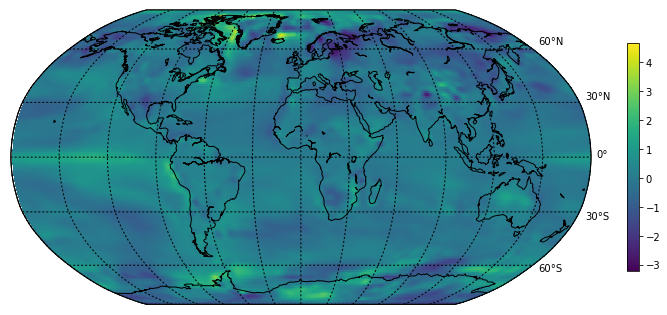

<module 'matplotlib.pyplot' from '/Users/dan/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [31]:
# Why are the HadCM3 amplitudes so much larger?


ad[1]['model_name']

wd.plotMap_nl(lon_g,lat_g,ad[1]['data'][:,500].reshape(len(lat_g),len(lon_g)),'')




/Users/dan/anaconda/envs/py27/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/Users/dan/anaconda/envs/py27/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/dan/anaconda/envs/py27/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


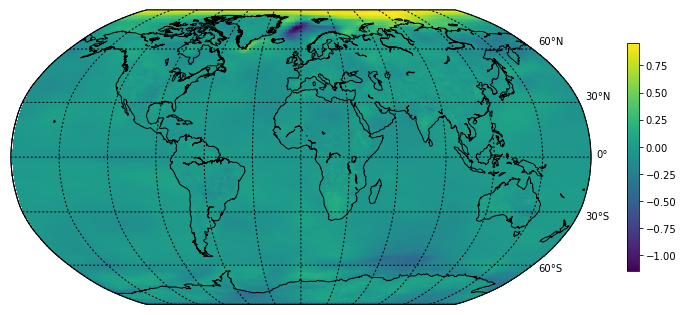

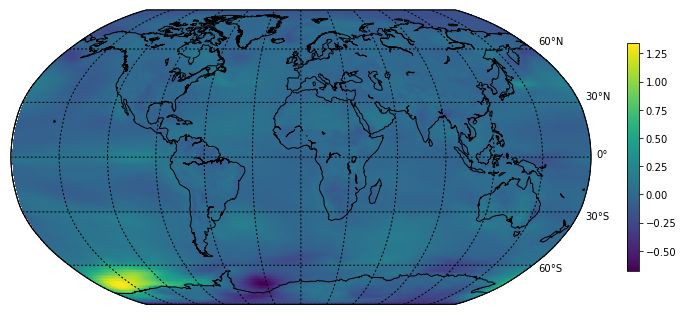

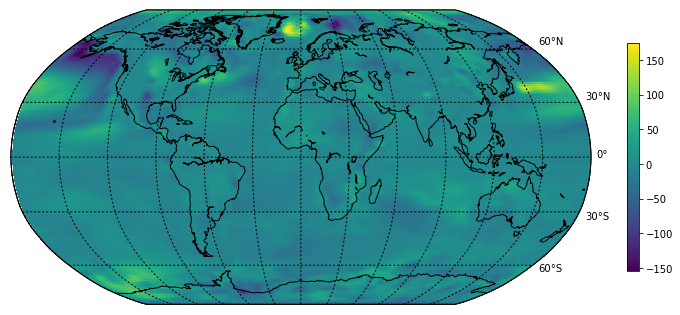

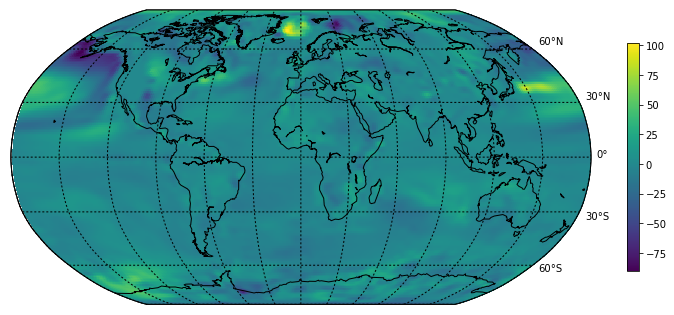

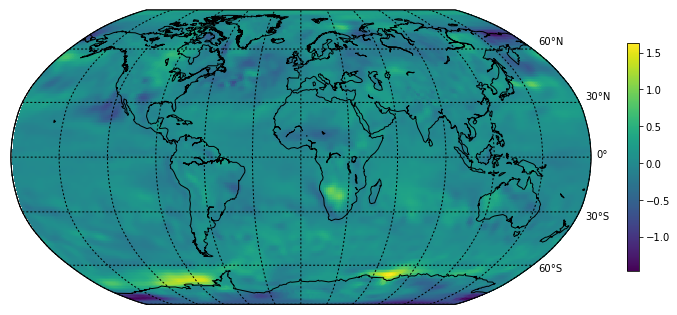

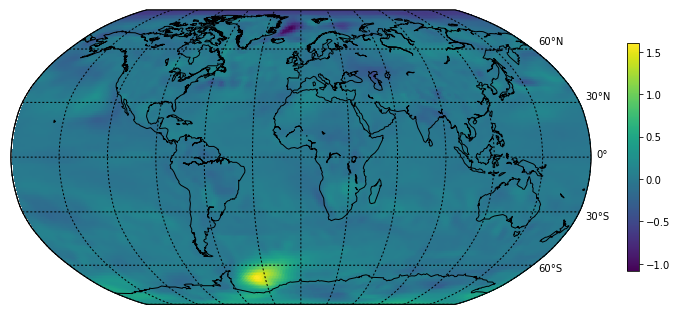

In [19]:
# Make some plots!



for ii in np.arange(len(cd)):
    pname = cd[ii]['Prior']
    tname = cd[ii]['Truth']
    fp    = cd[ii]['Filtered truth ensemble using PAGES2k']
    fc    = cd[ii]['Filtered truth ensemble using complete obs']
    ufp   = cd[ii]['Eigenvectors of nullspace unc using PAGES2k']
    ufc   = cd[ii]['Eigenvectors of nullspace unc using complete obs']
    sfp   = cd[ii]['Eigenvalues of nullspace unc using PAGES2k']
    sfc   = cd[ii]['Eigenvalues of nullspace unc using complete obs']
    
    wd.plotMap_nl(lon_g,lat_g,sfp[0]**.5*ufp[:,0].reshape(len(lat_g),len(lon_g)),'')

